In [1]:
%reload_ext autoreload
%autoreload 2

## Import packages

In [2]:
from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    add_new_deep_sup,
)
from ripple_heterogeneity.replay import (
    replay_run,
    replay_participation_all_replays,
)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import pickle
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator
import logging

logging.basicConfig(level=logging.INFO)


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## default plotting

In [5]:
functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

## Load replay data

In [4]:
# save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\replay_v7"
# save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\replay'
save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\replay_82422'

replay_df = replay_run.load_results(save_path, pre_task_post=False)


## run replay participation analysis

replay_participation_all_replays

In [9]:
# replay_participation_all_replays.handle_epochs(
#     "Z:\Data\GrosmarkAD\Achilles\Achilles_10252013",
#     ["sleep", "linear", "sleep"],
#     ["linear", "sleep"],
#     ["sleep", "linear"],
# )


(<EpochArray at 0x16aa1e0dd00: 2 epochs> of length 9:41:01:103 hours,
 array(['sleep', 'linear_sleep'], dtype=object))

In [10]:
# temp_df = replay_participation_all_replays.run("Z:\Data\GrosmarkAD\Achilles\Achilles_10252013",
#     replay_df=replay_df,
#     replay_save_path=save_path,
#     environments=["sleep", "linear", "sleep"],
#     min_env_criteria = ["sleep", "linear"],
#     epochs_to_combine=["linear", "sleep"])

# get many types of participation and firing

* combine linear and following sleep sessions to calc participation

* if no post sleep, only calc on linear track

* capture pre sleep participation



In [6]:
# save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\replay_v7"
# save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\replay'
save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\replay_82422'

# save_path_cur_analysis = (
#     r"Z:\home\ryanh\projects\ripple_heterogeneity\replay_participation_for_v7_sessions_task_post"
# )
# save_path_cur_analysis = (
#     r"Z:\home\ryanh\projects\ripple_heterogeneity\replay_participation_for_all_sessions_sleep_task_sleep"
# )
save_path_cur_analysis = (
    r"Z:\home\ryanh\projects\ripple_heterogeneity\replay_participation_for_all_sessions_sleep_task_sleep_v2"
)
batch_analysis.run(
    replay_df,
    save_path_cur_analysis,
    replay_participation_all_replays.run,
    parallel=True,
    verbose=True,
    overwrite=False,
    skip_if_error=False,
    replay_df=replay_df,
    replay_save_path=save_path,
    environments=["sleep", "linear", "sleep"],
    min_env_criteria = ["sleep", "linear"],
    epochs_to_combine=["linear", "sleep"],
    alpha=0.05,
    min_spk_count=0,
)

# read back in
# save_path_cur_analysis = (
#     r"Z:\home\ryanh\projects\ripple_heterogeneity\replay_participation_for_v7_sessions_task_post"
# )
sessions = glob.glob(save_path_cur_analysis + os.sep + "*.pkl")
par_df = pd.DataFrame()
for session in sessions:
    with open(session, "rb") as f:
        results = pickle.load(f)
    par_df = pd.concat([par_df, results])


100%|██████████| 91/91 [00:08<00:00, 11.12it/s]


## add deep sup class from deep sup distance

In [7]:
par_df = add_new_deep_sup.deep_sup_from_deepSuperficialDistance(par_df)
for basepath in par_df.basepath.unique():
    par_df.loc[par_df.basepath == basepath, "animal_id"] = loading.get_animal_id(basepath)


## plot replay partic prob. between layers

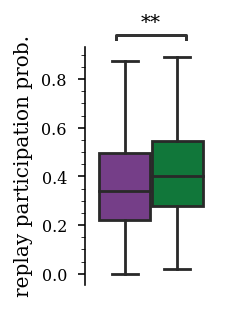

In [20]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(3, 1)), edgecolor=None
)
group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))

# keep_idx = (par_df.n_replays > 30) & (~par_df.basepath.str.contains('GirardeauG'))
keep_idx = (par_df.n_replays > 30) & (par_df.epoch.str.contains("linear"))

sns.boxplot(
    x="epoch",
    y="replay_par",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    showfliers=False,
)
# sns.stripplot(
#     x="epoch",
#     y="replay_par",
#     hue="deepSuperficial",
#     hue_order=group_colors.keys(),
#     data=par_df[keep_idx],
#     dodge=True,
#     color="k",
#     size=3,
#     alpha=0.25,
#     jitter=0.2,
# )
# sns.violinplot(
#     x="epoch",
#     y="replay_par",
#     hue="deepSuperficial",
#     hue_order=group_colors.keys(),
#     data=par_df[keep_idx],
#     dodge=True,
#     size=1.5,
#     alpha=1,
# )
plt.legend(
    bbox_to_anchor=(2, 1),
    loc="upper right",
    fancybox=False,
    shadow=False,
    ncol=1,
    frameon=False,
)
sns.despine()
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.axes.get_xaxis().set_ticks([])
ax.spines["bottom"].set_visible(False)
ax.get_legend().remove()
ax.set_xlabel("")
ax.set_ylabel("replay participation prob.")

box_pairs = [
    (("linear_sleep", "Deep"),("linear_sleep", "Superficial")),
]
annotator = Annotator(
    plt.gca(),
    box_pairs,
    data=par_df[keep_idx],
    x="epoch",
    y="replay_par",
    hue="deepSuperficial",
)
annotator.configure(
    test="Mann-Whitney",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=0,
)
annotator.apply_and_annotate()
# ax.set_ylim(-0.01,1)
plt.savefig(
    os.path.join(fig_save_path, "replay_participation_08_26_22.svg"),
    dpi=300,
    bbox_inches="tight",
)


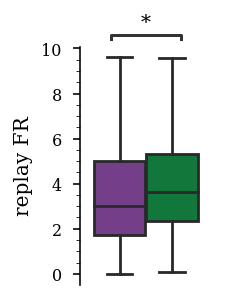

In [21]:
from statannotations.Annotator import Annotator
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(3, 1)), edgecolor=None
)
sns.boxplot(
    x="epoch",
    y="replay_fr",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    showfliers=False,
)
sns.despine()
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.axes.get_xaxis().set_ticks([])
ax.spines["bottom"].set_visible(False)
ax.get_legend().remove()
ax.set_xlabel("")
ax.set_ylabel("replay FR")

box_pairs = [
    (("linear_sleep", "Deep"),("linear_sleep", "Superficial")),
]
annotator = Annotator(
    plt.gca(),
    box_pairs,
    data=par_df[keep_idx],
    x="epoch",
    y="replay_fr",
    hue="deepSuperficial",
)
annotator.configure(
    test="Mann-Whitney",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=0,
)
annotator.apply_and_annotate()

plt.savefig(
    os.path.join(fig_save_path, "replay_fr_08_26_22.svg"),
    dpi=300,
    bbox_inches="tight",
)

## See replay firing rate gain

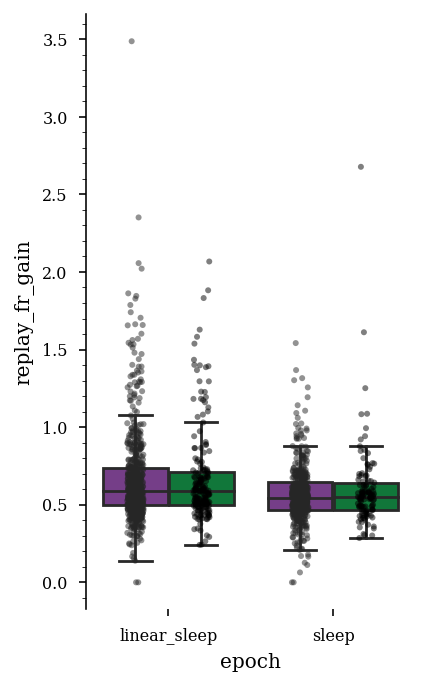

In [45]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.5, subplots=(3, 1)), edgecolor=None
)
group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))

par_df["replay_fr_gain"] = par_df["replay_fr"] / par_df["non_replay_fr"]

# keep_idx = (par_df.n_replays > 30) & (~par_df.basepath.str.contains('GirardeauG'))
keep_idx = (par_df.n_replays > 30)

sns.boxplot(
    x="epoch",
    y="replay_fr_gain",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    showfliers=False,
)
sns.stripplot(
    x="epoch",
    y="replay_fr_gain",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    dodge=True,
    color="k",
    size=3,
    alpha=0.5,
)
plt.legend(
    bbox_to_anchor=(2, 1),
    loc="upper right",
    fancybox=False,
    shadow=False,
    ncol=1,
    frameon=False,
)
sns.despine()
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
# ax.axes.get_xaxis().set_ticks([])
ax.spines["bottom"].set_visible(False)
ax.get_legend().remove()
# ax.set_xlabel("")
# ax.set_ylabel("non_replay_fr firing rate (Hz)")

# ax.set_yscale("log")
# plt.savefig(
#     os.path.join(fig_save_path, "replay_fr_05_11_22.svg"),
#     dpi=300,
#     bbox_inches="tight",
# )
# par_df[keep_idx].basepath.unique()

## Test python mixed lm model

In [46]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import LabelEncoder

temp_df = par_df[(par_df.deepSuperficial != "middle") & (par_df.n_replays > 30)]

lbl=LabelEncoder()
temp_df['basepath_encoded'] = lbl.fit_transform(temp_df[['basepath']])
temp_df['deepSuperficial_encoded'] = lbl.fit_transform(temp_df[['deepSuperficial']])

temp_df["Intercept"] = 1
exog = temp_df[["Intercept", "deepSuperficial_encoded"]]
md = sm.MixedLM(temp_df["replay_par"], exog, groups=temp_df["basepath_encoded"], exog_re=exog["Intercept"])
mdf = md.fit()
print(mdf.summary())

              Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    replay_par
No. Observations:    1422       Method:                REML      
No. Groups:          34         Scale:                 0.0345    
Min. group size:     8          Log-Likelihood:        331.8415  
Max. group size:     140        Converged:             Yes       
Mean group size:     41.8                                        
-----------------------------------------------------------------
                        Coef. Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               0.405    0.017 23.321 0.000  0.371  0.439
deepSuperficial_encoded 0.037    0.013  2.780 0.005  0.011  0.064
Intercept Var           0.009    0.014                           



## Forward / Reverse 

make wide to long df

In [47]:
keep_idx = (par_df.n_replays > 30) & (par_df.epoch.str.contains("linear"))

par_df_long = pd.melt(
    par_df[keep_idx],
    id_vars=["basepath", "UID", "deepSuperficial"],
    value_vars=["forward_replay_par", "reverse_replay_par"],
    var_name="replay_type",
    value_name="replay_participation",
)
par_df_long


,basepath,UID,deepSuperficial,replay_type,replay_participation
0,Z:\Data\AYAold\AYA6\day17,25,Superficial,forward_replay_par,0.187500
1,Z:\Data\AYAold\AYA6\day17,27,Deep,forward_replay_par,0.312500
2,Z:\Data\AYAold\AYA6\day17,29,Superficial,forward_replay_par,0.062500
3,Z:\Data\AYAold\AYA6\day17,30,Superficial,forward_replay_par,0.125000
4,Z:\Data\AYAold\AYA6\day17,31,Superficial,forward_replay_par,0.000000
...,...,...,...,...,...
2447,Z:\Data\Kenji\ec014.459_480,75,Deep,reverse_replay_par,0.620690
2448,Z:\Data\Kenji\ec014.459_480,76,Deep,reverse_replay_par,0.413793
2449,Z:\Data\Kenji\ec014.459_480,77,Deep,reverse_replay_par,0.241379
2450,Z:\Data\Kenji\ec014.459_480,82,Deep,reverse_replay_par,0.500000


### look at forward and reverse

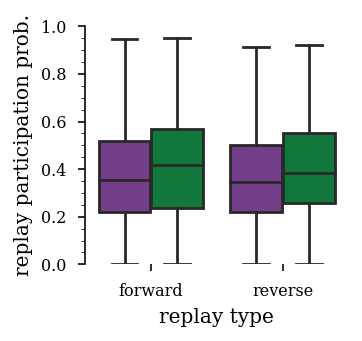

In [92]:
# fig = plt.figure(
#     figsize=functions.set_size("thesis", fraction=0.2, subplots=(3, 1)), edgecolor=None
# )
w,h = functions.set_size("thesis", fraction=0.2, subplots=(3, 1))

fig = plt.figure(
    figsize=(w*2,h), edgecolor=None
)
group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))

g=sns.boxplot(
    x="replay_type",
    y="replay_participation",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df_long,
    showfliers=False,
)
ax = plt.gca()
ax.get_legend().remove()
sns.despine()
ax.yaxis.set_minor_locator(AutoMinorLocator())
# ax.axes.get_xaxis().set_ticks([])
ax.spines["bottom"].set_visible(False)
# ax.get_legend().remove()
# ax.set_xlabel("")
# plt.xticks(['forward','reverse'], rotation='vertical')
ax.set_ylabel("replay participation prob.")
ax.set_xlabel("replay type")
g.set_xticklabels(['forward','reverse'])

ax.set_ylim(0,1)

plt.savefig(
    os.path.join(fig_save_path, "replay_participation_for_rev.svg"),
    dpi=300,
    bbox_inches="tight",
)

In [49]:
par_df_long['replay_type_ca1_layer'] = par_df_long['replay_type'] + '_' + par_df_long['deepSuperficial']
par_df_long['replay_type_ca1_layer'].unique()

array(['forward_replay_par_Superficial', 'forward_replay_par_Deep',
       'forward_replay_par_middle', 'reverse_replay_par_Superficial',
       'reverse_replay_par_Deep', 'reverse_replay_par_middle'],
      dtype=object)

### paired plot of forward and reverse

<AxesSubplot:xlabel='replay_type', ylabel='replay_participation'>

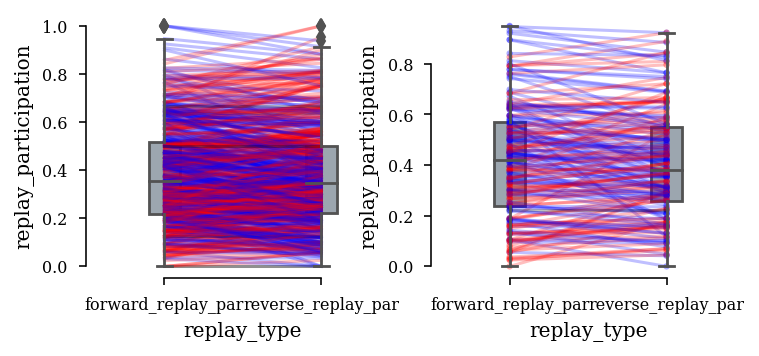

In [50]:
import pingouin as pg

fig, axs = plt.subplots(1, 2, figsize=functions.set_size(
    'thesis', fraction=1, subplots=(2, 3)), edgecolor='k')
fig.subplots_adjust(hspace=.2, wspace=.1)
axs = axs.ravel()

ax = plt.gca()
par_df_long["basepath_UID"] = par_df_long.basepath + "_" + par_df_long.UID.astype(str)

pg.plot_paired(
    data=par_df_long[par_df_long.deepSuperficial == "Deep"],
    dv="replay_participation",
    within="replay_type",
    subject="basepath_UID",
    ax=axs[0],
    pointplot_kwargs={"alpha": 0.25, "s": .5},colors=['r','k','b'],
)
pg.plot_paired(
    data=par_df_long[par_df_long.deepSuperficial == "Superficial"],
    dv="replay_participation",
    within="replay_type",
    subject="basepath_UID",
    ax=axs[1],
    pointplot_kwargs={"alpha": 0.25},colors=['r','k','b']
)

In [51]:
# par_df["forward_reverse_ratio"] = (
#     par_df.forward_replay_par - par_df.reverse_replay_par
# ) / (par_df.forward_replay_par + par_df.reverse_replay_par)

# par_df["forward_reverse_ratio"] = (
#     par_df.forward_replay_par - par_df.reverse_replay_par
# )

par_df["forward_reverse_ratio"] = (
    par_df.forward_replay_par / par_df.reverse_replay_par
)

In [52]:
(par_df[par_df.deepSuperficial == "Deep"].forward_reverse_ratio > 1).sum()
(par_df[par_df.deepSuperficial == "Deep"].forward_reverse_ratio < 1).sum()

(par_df[par_df.deepSuperficial == "Superficial"].forward_reverse_ratio > 1).sum(),(par_df[par_df.deepSuperficial == "Superficial"].forward_reverse_ratio < 1).sum()

(335, 325)

### Forward / Reverse for main fig

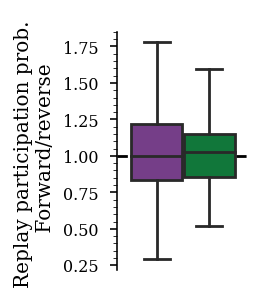

In [53]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(3, 1)), edgecolor=None
)
group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))

sns.boxplot(
    x="epoch",
    y="forward_reverse_ratio",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    showfliers=False,
)
    # boxprops=dict(alpha=.7)

# sns.stripplot(
#     x="epoch",
#     y="forward_reverse_ratio",
#     hue="deepSuperficial",
#     hue_order=group_colors.keys(),
#     data=par_df[keep_idx],
#     dodge=True,
#     color="k",
#     size=3,
#     alpha=0.5,
# )
plt.legend(
    bbox_to_anchor=(2, 1),
    loc="upper right",
    fancybox=False,
    shadow=False,
    ncol=1,
    frameon=False,
)
sns.despine()
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.axes.get_xaxis().set_ticks([])
ax.spines["bottom"].set_visible(False)
ax.get_legend().remove()
ax.set_xlabel("")
ax.axhline(1, linestyle="--", color="k",zorder=-1000)

ax.set_ylabel("Replay participation prob. \n Forward/reverse")

plt.savefig(
    os.path.join(fig_save_path, "replay_participation_replay_type.svg"),
    dpi=300,
    bbox_inches="tight",
)

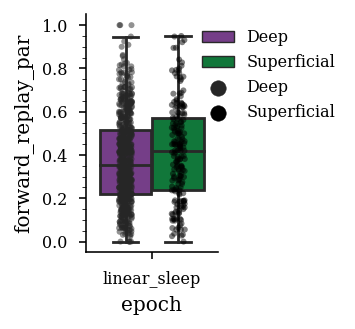

In [54]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(3, 1)), edgecolor=None
)

sns.boxplot(
    x="epoch",
    y="forward_replay_par",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    showfliers=False,
)
sns.stripplot(
    x="epoch",
    y="forward_replay_par",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    dodge=True,
    color="k",
    size=3,
    alpha=0.5,
)
plt.legend(
    bbox_to_anchor=(2, 1),
    loc="upper right",
    fancybox=False,
    shadow=False,
    ncol=1,
    frameon=False,
)
sns.despine()
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
# plt.yscale("log")

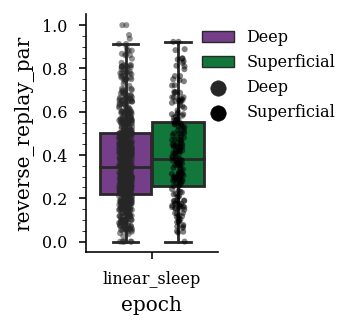

In [55]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(3, 1)), edgecolor=None
)

sns.boxplot(
    x="epoch",
    y="reverse_replay_par",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    showfliers=False,
)
sns.stripplot(
    x="epoch",
    y="reverse_replay_par",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    dodge=True,
    color="k",
    size=3,
    alpha=0.5,
)
plt.legend(
    bbox_to_anchor=(2, 1),
    loc="upper right",
    fancybox=False,
    shadow=False,
    ncol=1,
    frameon=False,
)
sns.despine()
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
# plt.yscale("log")

## calculate firing rate gain

$replayGain = \frac{replay fr}{avg fr}$

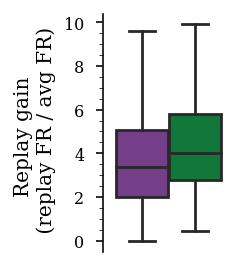

In [108]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(3, 1)), edgecolor=None
)

# par_df["replay_df_gain_avg_to_replay"] = (par_df.replay_fr-par_df.non_ripple_avg_fr)/(par_df.replay_fr+par_df.non_ripple_avg_fr)
par_df["replay_df_gain_avg_to_replay"] = par_df.replay_fr / par_df.non_ripple_avg_fr

keep_idx = (
    (par_df.n_replays > 30)
    & (par_df.animal_id != "Rat08")
    & (par_df.animal_id != "Gatsby")
    & (par_df.animal_id != "OML22")
    & (par_df.epoch.str.contains("linear"))
)

sns.boxplot(
    x="epoch",
    y="replay_df_gain_avg_to_replay",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    showfliers=False,
)

# sns.stripplot(
#     x="epoch",
#     y="replay_df_gain_avg_to_replay",
#     hue="deepSuperficial",
#     hue_order=group_colors.keys(),
#     data=par_df[keep_idx],
#     dodge=True,
#     color="k",
#     size=3,
#     alpha=0.5,
# )
plt.legend(
    bbox_to_anchor=(2, 1),
    loc="upper right",
    fancybox=False,
    shadow=False,
    ncol=1,
    frameon=False,
)

sns.despine()
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.axes.get_xaxis().set_ticks([])
ax.spines["bottom"].set_visible(False)
ax.get_legend().remove()
ax.set_xlabel("")
# ax.axhline(1, linestyle="--", color="k",zorder=-1000)
ax.set_ylabel("Replay gain \n (replay FR / avg FR)")

plt.savefig(
    os.path.join(fig_save_path, "replay_fr_over_avg_fr.svg"),
    dpi=300,
    bbox_inches="tight",
)

<AxesSubplot:xlabel='animal_id', ylabel='replay_df_gain_avg_to_replay'>

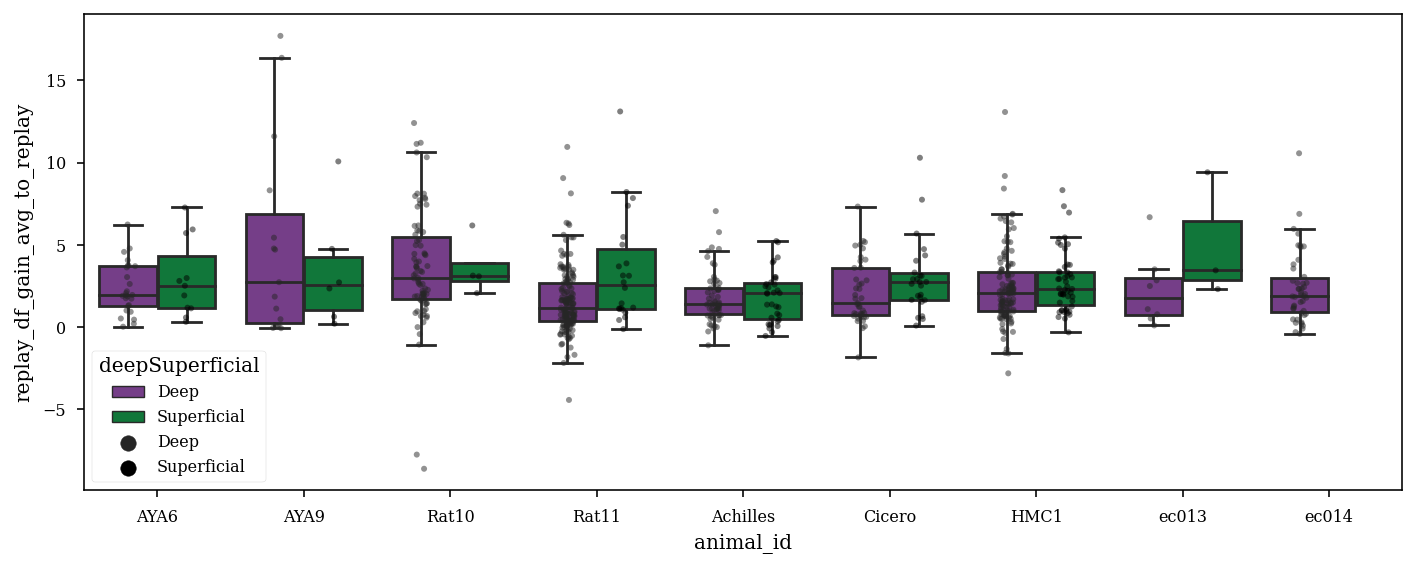

In [109]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=2, subplots=(3, 5)), edgecolor=None
)
par_df["replay_df_gain_avg_to_replay"] = (par_df.replay_fr-par_df.non_ripple_avg_fr)

sns.boxplot(
    x="animal_id",
    y="replay_df_gain_avg_to_replay",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    showfliers=False,
)
sns.stripplot(
    x="animal_id",
    y="replay_df_gain_avg_to_replay",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    dodge=True,
    color="k",
    size=3,
    alpha=0.5,
)

In [58]:
par_df.epoch.unique()

array(['sleep', 'linear', 'linear_sleep'], dtype=object)

In [59]:
for animal_id in par_df[keep_idx].animal_id.unique():
    print(animal_id, ' deep ', sum((par_df[keep_idx].animal_id == animal_id) & (par_df[keep_idx].deepSuperficial == "Deep")))
    print(animal_id, ' sup ', sum((par_df[keep_idx].animal_id == animal_id) & (par_df[keep_idx].deepSuperficial == "Superficial")))


AYA6  deep  26
AYA6  sup  11
AYA9  deep  15
AYA9  sup  6
OML22  deep  68
OML22  sup  25
Rat10  deep  79
Rat10  sup  4
Rat11  deep  158
Rat11  sup  22
Achilles  deep  59
Achilles  sup  34
Cicero  deep  41
Cicero  sup  25
HMC1  deep  119
HMC1  sup  50
ec013  deep  8
ec013  sup  3
ec014  deep  46
ec014  sup  0


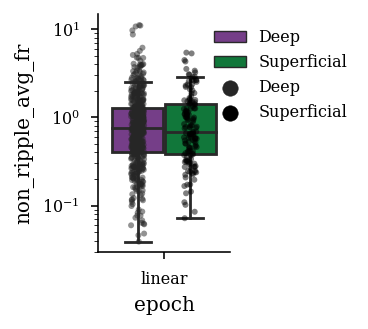

In [115]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(3, 1)), edgecolor=None
)

sns.boxplot(
    x="epoch",
    y="non_ripple_avg_fr",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    showfliers=False,
)

sns.stripplot(
    x="epoch",
    y="non_ripple_avg_fr",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    dodge=True,
    color="k",
    size=3,
    alpha=0.5,
)
plt.legend(
    bbox_to_anchor=(2, 1),
    loc="upper right",
    fancybox=False,
    shadow=False,
    ncol=1,
    frameon=False,
)
sns.despine()
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())

plt.yscale("log")

## Ripple gain pre-sleep norm

$replayGain = \frac{ReplayFr}{preSleepAvgFr}$


In [18]:
# par_df_wide = pd.pivot(
#     par_df[keep_idx], index=["UID","basepath","deepSuperficial"], columns="epoch", values=["replay_fr","avg_fr"]
# ).reset_index()
# par_df_wide

# par_df_wide["replay_gain"] = par_df_wide["replay_fr"]["linear_sleep"] / par_df_wide["avg_fr"]["sleep"]
# # par_df_wide["avg_fr"]["sleep"]
# par_df_wide

In [19]:
# par_df_wide[par_df_wide.basepath == "Z:\Data\GrosmarkAD\Achilles\Achilles_10252013"]
# par_df[par_df.basepath == "Z:\Data\GrosmarkAD\Achilles\Achilles_10252013"].epoch.value_counts()

# par_df

In [104]:
par_df[keep_idx].basepath.unique()

array(['Z:\\Data\\AYAold\\AYA6\\day17', 'Z:\\Data\\AYAold\\AYA9\\day17',
       'Z:\\Data\\Can\\OML22\\day19', 'Z:\\Data\\Can\\OML22\\day6',
       'Z:\\Data\\Can\\OML22\\day7', 'Z:\\Data\\Can\\OML22\\day8',
       'Z:\\Data\\GirardeauG\\Rat08\\Rat08-20130717',
       'Z:\\Data\\GirardeauG\\Rat10\\Rat10-20140619',
       'Z:\\Data\\GirardeauG\\Rat10\\Rat10-20140622',
       'Z:\\Data\\GirardeauG\\Rat10\\Rat10-20140624',
       'Z:\\Data\\GirardeauG\\Rat10\\Rat10-20140627',
       'Z:\\Data\\GirardeauG\\Rat10\\Rat10-20140703',
       'Z:\\Data\\GirardeauG\\Rat10\\Rat10-20140704',
       'Z:\\Data\\GirardeauG\\Rat10\\Rat10-20140705',
       'Z:\\Data\\GirardeauG\\Rat11\\Rat11-20150310',
       'Z:\\Data\\GirardeauG\\Rat11\\Rat11-20150315',
       'Z:\\Data\\GirardeauG\\Rat11\\Rat11-20150316',
       'Z:\\Data\\GirardeauG\\Rat11\\Rat11-20150326',
       'Z:\\Data\\GirardeauG\\Rat11\\Rat11-20150327',
       'Z:\\Data\\GirardeauG\\Rat11\\Rat11-20150328',
       'Z:\\Data\\GirardeauG\\Rat11\

In [125]:
par_df[par_df.basepath == "Z:\\Data\\Can\\OML22\\day8"].n_replays

0     29
1     29
2     29
3     29
4     29
      ..
83    47
84    47
85    47
86    47
87    47
Name: n_replays, Length: 88, dtype: int32

In [126]:
keep_idx = par_df.n_replays > 28

par_df_wide = pd.pivot(
    par_df[keep_idx],
    index=["UID", "basepath", "deepSuperficial"],
    columns="epoch",
    values=["replay_fr", "avg_fr"],
).reset_index()

par_df_wide["replay_gain"] = par_df_wide["replay_fr"]["linear_sleep"] / par_df_wide["avg_fr"]["sleep"]
# par_df_wide["replay_gain"] = (
#     par_df_wide["replay_fr"]["linear_sleep"] - par_df_wide["avg_fr"]["sleep"]
# ) / (par_df_wide["replay_fr"]["linear_sleep"] + par_df_wide["avg_fr"]["sleep"])

par_df_wide["constant"] = 1

for basepath in par_df_wide.basepath.unique():
    par_df_wide.loc[
        par_df_wide.basepath == basepath, "animal_id"
    ] = loading.get_animal_id(basepath)
par_df_wide = par_df_wide[
    ["UID", "basepath", "deepSuperficial", "animal_id", "replay_gain", "constant"]
]
par_df_wide = par_df_wide[~np.isnan(par_df_wide.replay_gain)]
par_df_wide


,UID,basepath,deepSuperficial,animal_id,replay_gain,constant
epoch,,,,,,
2,1,Z:\Data\Can\OML22\day8,Superficial,OML22,3.444390,1
3,1,Z:\Data\GrosmarkAD\Achilles\Achilles_11012013,Deep,Achilles,4.485374,1
4,1,Z:\Data\GrosmarkAD\Cicero\Cicero_09102014,Deep,Cicero,2.840216,1
5,1,Z:\Data\GrosmarkAD\Cicero\Cicero_09172014,Deep,Cicero,5.596996,1
7,1,Z:\Data\Kenji\ec014.459_480,Deep,ec014,16.773367,1
...,...,...,...,...,...,...
1260,304,Z:\Data\HMC1\day9,middle,HMC1,4.851994,1
1261,305,Z:\Data\HMC1\day9,Deep,HMC1,1.781830,1
1262,308,Z:\Data\HMC1\day9,middle,HMC1,2.882403,1


In [127]:
# describe par_df_wide
par_df_wide.describe()
print(par_df_wide.basepath.value_counts())
print(par_df_wide.deepSuperficial.value_counts())


Z:\Data\GrosmarkAD\Achilles\Achilles_10252013    104
Z:\Data\GrosmarkAD\Achilles\Achilles_11012013     90
Z:\Data\HMC1\day10                                78
Z:\Data\HMC1\day9                                 58
Z:\Data\GrosmarkAD\Cicero\Cicero_09102014         55
Z:\Data\GirardeauG\Rat11\Rat11-20150331           52
Z:\Data\Kenji\ec014.459_480                       49
Z:\Data\Can\OML22\day8                            44
Z:\Data\GrosmarkAD\Cicero\Cicero_09172014         42
Z:\Data\GrosmarkAD\Gatsby\Gatsby_08022013         36
Z:\Data\GrosmarkAD\Cicero\Cicero_09012014         34
Z:\Data\GirardeauG\Rat11\Rat11-20150327           31
Z:\Data\GirardeauG\Rat11\Rat11-20150330           30
Z:\Data\GirardeauG\Rat11\Rat11-20150310           28
Z:\Data\GirardeauG\Rat10\Rat10-20140619           27
Z:\Data\GirardeauG\Rat11\Rat11-20150328           26
Z:\Data\GirardeauG\Rat10\Rat10-20140622           21
Z:\Data\GirardeauG\Rat10\Rat10-20140624           18
Z:\Data\GirardeauG\Rat11\Rat11-20150315       

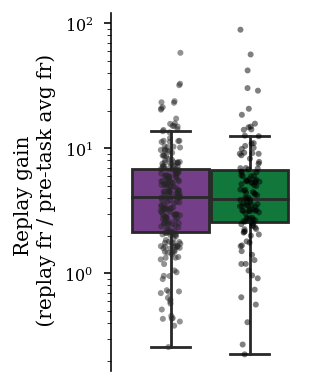

In [146]:

fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.3, subplots=(3, 1)), edgecolor=None
)

# keep_idx = (
#     (par_df_wide.animal_id != "Gatsby")
#     & (par_df_wide.animal_id != "ec014")
#     & (par_df_wide.animal_id != "achilles")
#     & (par_df_wide.animal_id != "Rat11")
# )
par_df_wide["consider_remove"] = False
for basepath in par_df_wide.basepath.unique():
    deep_idx = np.sum(par_df_wide[par_df_wide.basepath == basepath].deepSuperficial == "Deep") > 0
    sup_idx = np.sum(par_df_wide[par_df_wide.basepath == basepath].deepSuperficial == "Superficial") > 0
    if not deep_idx or not sup_idx:
        par_df_wide.loc[par_df_wide.basepath == basepath,"consider_remove"] = True

keep_idx = par_df_wide.consider_remove == False

sns.boxplot(
    x="constant",
    y="replay_gain",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df_wide[keep_idx],
    showfliers=False,
)

sns.stripplot(
    x="constant",
    y="replay_gain",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df_wide[keep_idx],
    dodge=True,
    color="k",
    size=3,
    alpha=0.5,
)
plt.legend(
    bbox_to_anchor=(2, 1),
    loc="upper right",
    fancybox=False,
    shadow=False,
    ncol=1,
    frameon=False,
)

sns.despine()
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.axes.get_xaxis().set_ticks([])
ax.spines["bottom"].set_visible(False)
ax.get_legend().remove()
ax.set_xlabel("")
# ax.axhline(1, linestyle="--", color="k",zorder=-1000)

ax.set_ylabel("Replay gain \n (replay fr / pre-task avg fr)")
plt.yscale("log")

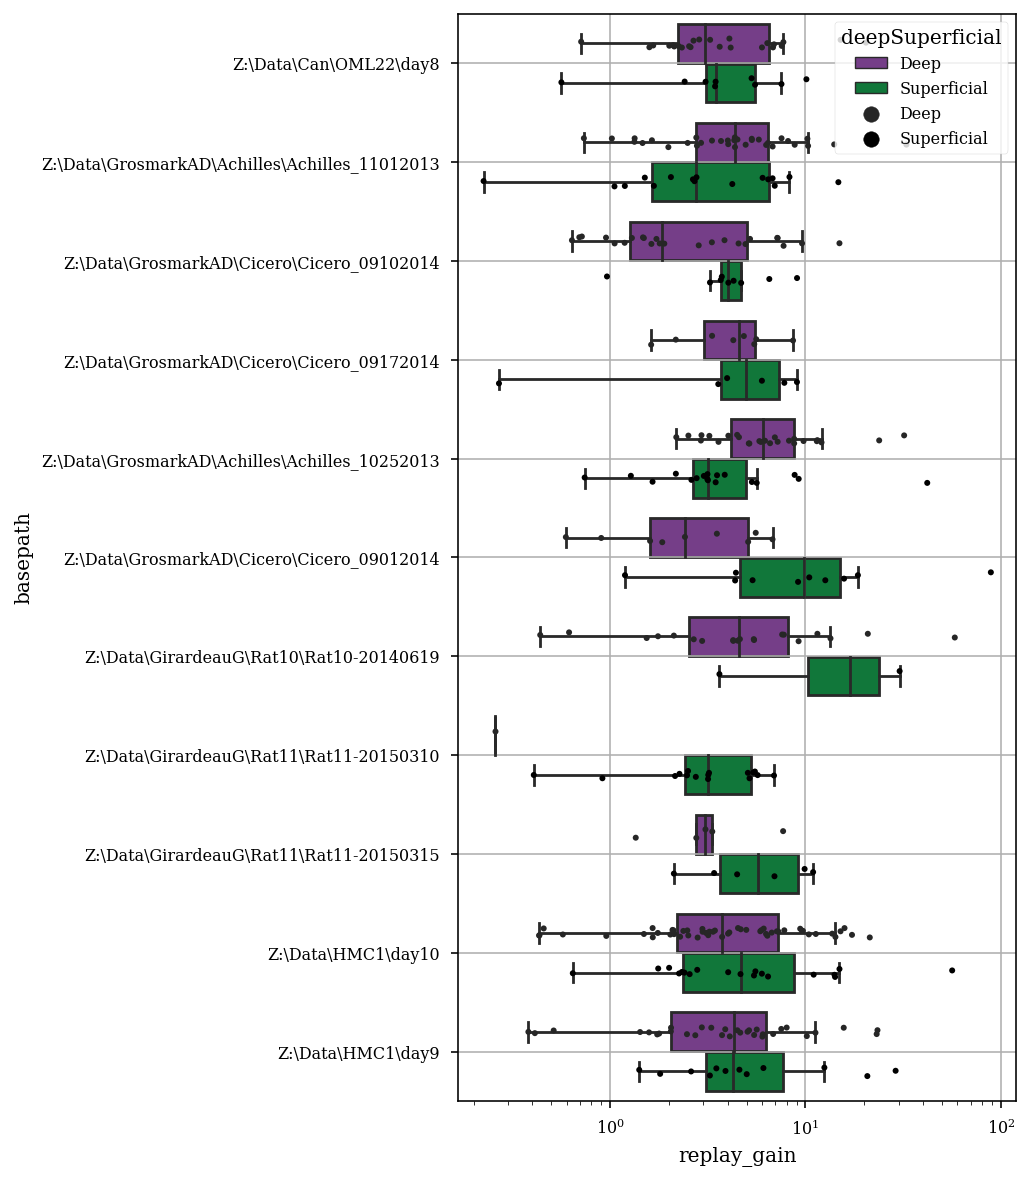

In [147]:
plt.figure(figsize=(5,10))
sns.boxplot(
    y="basepath",
    x="replay_gain",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df_wide[keep_idx],
    showfliers=False,
)
sns.stripplot(
    y="basepath",
    x="replay_gain",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df_wide[keep_idx],
    dodge=True,
    color="k",
    size=3,
    alpha=1,
)
plt.xscale("log")
plt.grid()

In [148]:
par_df_wide.to_csv(
    r"Z:\home\ryanh\projects\ripple_heterogeneity\replay_participation_for_all_sessions_task_post_replay_gain.csv"
)

In [32]:
par_df.epoch.unique()

array(['sleep', 'linear', 'linear_sleep'], dtype=object)

## save csv

In [107]:
# par_df.to_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\replay_participation_for_v7_task_post.csv")
# replay_participation_for_all_sessions_task_post
par_df.to_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\replay_participation_for_all_sessions_task_post.csv")


## visualize with dabest

In [69]:
temp_df_1 = pd.DataFrame()
keep_idx = (par_df.n_replays > 30)
par_df['basepath_UID'] = par_df.basepath + "_" + par_df.UID.astype(str)

temp_df_1['forward'] = par_df[keep_idx & (par_df.deepSuperficial=="Deep")].forward_replay_par.values
temp_df_1['reverse'] = par_df[keep_idx & (par_df.deepSuperficial=="Deep")].reverse_replay_par.values
temp_df_1['ID'] = par_df[keep_idx & (par_df.deepSuperficial=="Deep")].basepath_UID.values
temp_df_1['deepSuperficial'] = ["Deep"] * len(temp_df_1)

temp_df_2 = pd.DataFrame()
temp_df_2['forward'] = par_df[keep_idx & (par_df.deepSuperficial=="Superficial")].forward_replay_par.values
temp_df_2['reverse'] = par_df[keep_idx & (par_df.deepSuperficial=="Superficial")].reverse_replay_par.values
temp_df_2['ID'] = par_df[keep_idx & (par_df.deepSuperficial=="Superficial")].basepath_UID.values

temp_df_2['deepSuperficial'] = ["Superficial"] * len(temp_df_2)
temp_df = pd.concat([temp_df_1, temp_df_2],ignore_index=True)
temp_df

,forward,reverse,ID,deepSuperficial
0,0.312500,0.352941,Z:\Data\AYAold\AYA6\day17_27,Deep
1,0.125000,0.235294,Z:\Data\AYAold\AYA6\day17_33,Deep
2,0.187500,0.411765,Z:\Data\AYAold\AYA6\day17_36,Deep
3,0.437500,0.470588,Z:\Data\AYAold\AYA6\day17_37,Deep
4,0.375000,0.294118,Z:\Data\AYAold\AYA6\day17_40,Deep
...,...,...,...,...
1417,0.282609,0.375000,Z:\Data\HMC1\day9_290,Superficial
1418,0.630435,0.625000,Z:\Data\HMC1\day9_309,Superficial
1419,0.450000,0.687500,Z:\Data\Kenji\ec013.634_653_61,Superficial
1420,0.950000,0.812500,Z:\Data\Kenji\ec013.634_653_66,Superficial


In [ ]:
import dabest
multi_2group_paired = dabest.load(temp_df[temp_df['deepSuperficial'] == "Deep"], idx=("forward", "reverse"),
                                paired=True, id_col=("ID")
                                )
multi_2group_paired.mean_diff.plot()


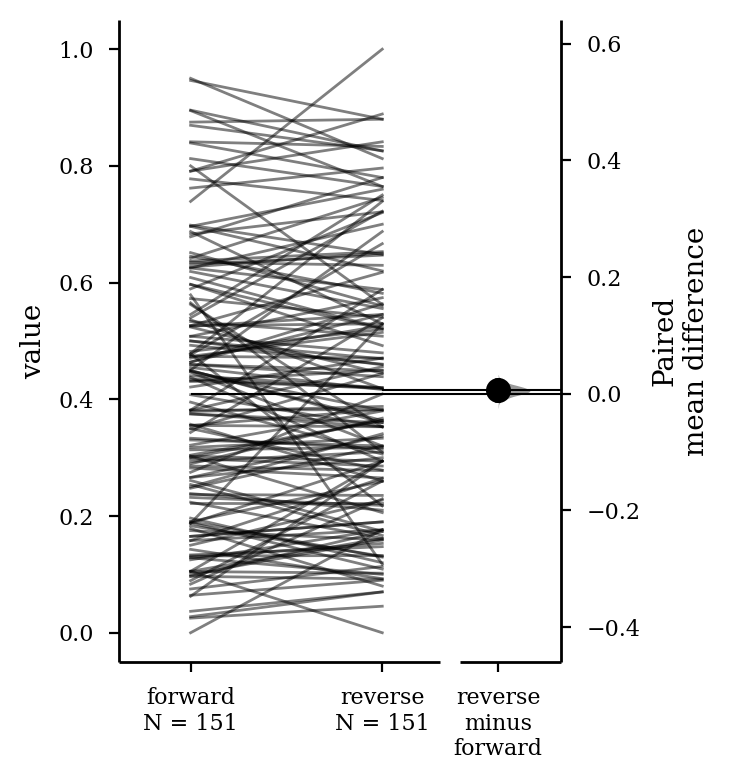

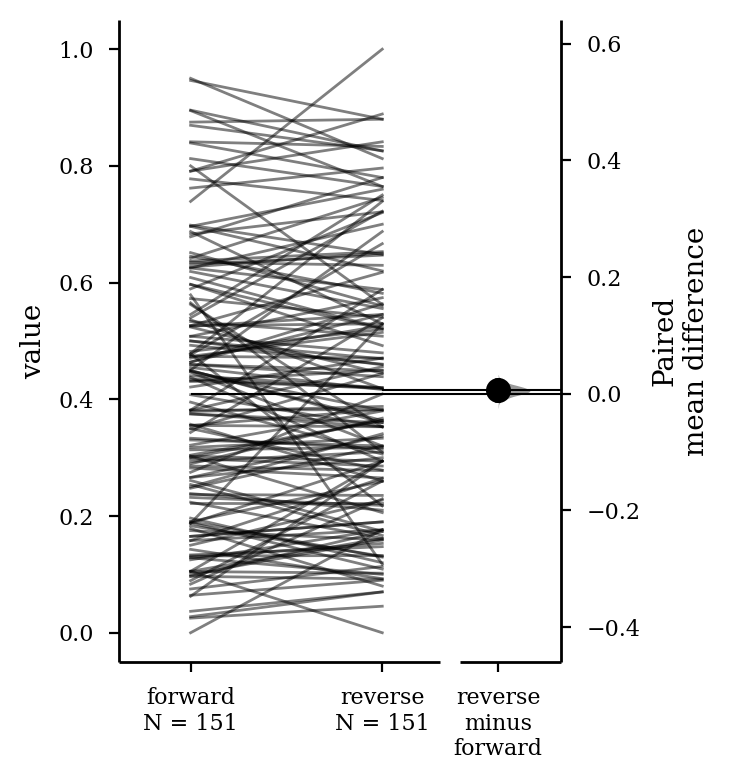

In [26]:
multi_2group_paired = dabest.load(temp_df[temp_df['deepSuperficial'] == "Superficial"], idx=("forward", "reverse"),
                                paired=True, id_col=("ID")
                                )
multi_2group_paired.mean_diff.plot()